In [1]:
import glob
import mne
import os
import re
from bs4 import BeautifulSoup
from keras import Sequential
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.src.utils import to_categorical
from joblib import dump
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import skew, kurtosis, entropy, mode
from scipy.signal import stft, welch
#from mne.time_frequency import psd_array_multitaper
#import antropy as ant  # For sample entropy and spectral entropy
#from pywt import wavedec
import antropy as ant
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU

**Ordner mit edf-Dateien suchen und vorbereiten**


In [2]:
def find_edf(directory):
    """
    Function to find the .edf files with ending [...] in a directory. 
    """
    paths = []
    pattern = r".*\[\d+\].edf"
    for filename in os.listdir(directory):
        if re.match(pattern, filename):
            filepath = os.path.join(directory, filename)
            paths.append(filepath)
    
    paths.sort()
    return paths

**Gewählte Kanäle aus EDF-Datei auslesen**

In [3]:
def files_preparation(path):
    """
    Read .edf File and choose channels
    """
    
    include = [
        'EEG C4-A1',
        'EEG C3-A2', 
        'EOG ROC-A1', 
        'EOG LOC-A2', 
        'EMG Chin',
        'ECG I', 
        'ECG II', 
        'EEG A1-A2'
    ]
    
    raw = mne.io.read_raw_edf(path, preload=True, verbose='error', include=include)
    
    raw.set_channel_types(
        mapping={
        'EEG C4-A1': 'eeg',
        'EEG C3-A2': 'eeg',
        'EEG A1-A2': 'eeg',
        'EOG ROC-A1': 'eog',
        'EOG LOC-A2': 'eog',
        'EMG Chin': 'emg',
        'ECG I': 'ecg',
        'ECG II': 'ecg'
        }
    )
    
    return raw

**Labels aus der dazugehörigen .rml-Datei auslesen**


In [4]:
def rml_to_annotations(directory, raw_data):
    """
    Reads .rml file and converts labels to for MNE.Epochs useable onset, describtion, duration.
    Where onset is the start of an Epoch, description is the label of the Epoch and duration is the duration of the Epoch.
    """
    
    os.chdir(directory)
    rml = None
    for file in glob.glob("*.rml"):
        rml = file
        break
    with open(rml, 'r') as f:
        rml_data = f.read()
    user_staging = BeautifulSoup(rml_data, 'xml').find("UserStaging").find("NeuroRKStaging")
    start_time = []
    sleep_stage = []
    for stage in user_staging.find_all('Stage'):
        start_time.append(int(stage['Start']))
        sleep_stage.append(stage['Type'])
        
    onset = np.array(start_time)
    description = np.array(sleep_stage)
    raw_duration = raw_data.times[-1] - raw_data.times[0]
    duration = np.diff(np.append(onset, raw_duration))
    return onset, description, duration

**Erstellt 30 Sekunden Epochen aus allen EDF-Dateien und den Labels und Preprocesseses die rohen Dateien**


In [5]:
tmax = 30 - 1 / 200 # tmax describes length of an Epoch

# Sleep stages acording to AASM
EVENTS_AASM = {
    "REM": 1,
    "NREM 1": 2,
    "NREM 2": 3,
    "NREM 3": 4,
    "Wake": 5,
}

def data_preparation(directory):
    """
    Function converts the raw edf files to MNE.Epochs and returns them.
    """
    
    print("Data from Directory:  ", directory)
    paths = find_edf(directory)
    data_list = []
    for path in paths:
        raw = files_preparation(path)
        data_list.append(raw)
    
    raw_data = mne.concatenate_raws(data_list)
    
    
    raw_data = raw_data.filter(
        picks='all',
        l_freq=0.5,
        h_freq=49.5,
        method='iir',
        iir_params=dict(order=10, ftype='butter'),
        verbose='error'
    ) 
    
    
    onset, description, duration = rml_to_annotations(directory, raw_data)
    annotations = mne.Annotations(onset=onset, description=description, duration=duration)
    annotations.crop(
        annotations[1]['onset'] - 30 * 20, # 30 * 60 = 1200 Ersten 10 Minuten entfernen
        annotations[-2]['onset'] + 30 * 20 # Letzten 10 Minuten entfernen
    )
    raw_data.set_annotations(annotations)
        
    events, _ = mne.events_from_annotations(
        raw_data, 
        chunk_duration=30,
        verbose='error'
    )
    
    epochs = mne.Epochs(
        raw=raw_data,
        events=events,
        event_id=EVENTS_AASM,
        tmin=0.0,
        baseline=None,
        tmax=tmax,
        verbose='error',
        on_missing='warn'
    )
    
    labels = epochs.events[:, 2]
    
    return epochs, labels

#### Feature Extraction


**1. Time Domain Features**

In [6]:
def mean(epochs):
    # Calculates Mean
    data = epochs.get_data(verbose='error')
    mean_features = np.mean(data, axis=2)
    return mean_features

def median(epochs):
    # Calculates Median
    data = epochs.get_data(verbose='error')
    median_features = np.median(data, axis=2)
    return median_features

def mode_feat(epochs):
    # Calculates Mode
    data = epochs.get_data(verbose='error')
    mode_features, _ = mode(data, axis=2)
    return mode_features

def minimum(epochs):
    # Calculates Minimum
    data = epochs.get_data(verbose='error')
    min_values = np.min(data, axis=2)
    return min_values

def maximum(epochs):
    # Calculates Minimum
    data = epochs.get_data(verbose='error')
    return np.max(data, axis=2)

def standard_derivation(epochs):
    # Calculates standard deviation
    data = epochs.get_data(verbose='error')
    std_features = np.std(data, axis=2)
    return std_features

def variance_skewness(epochs):
    # Calculates Variance Skewness
    data = epochs.get_data(verbose='error')
    variance_features = np.var(data, axis=2)
    return variance_features

def kurtosis_feat(epochs):
    # Calculates Kurtosis
    data = epochs.get_data(verbose='error')
    kurtosis_data = kurtosis(data, axis=2, fisher=False)
    return kurtosis_data

def percentile(epochs, percent = 50):
    # Calculates Percentile
    data = epochs.get_data(verbose='error')
    percentile_features = np.percentile(data, percent, axis=2)
    return percentile_features

def energy_sis(epochs):
    """
    Calculates the energy of the signals
    """
    
    data = epochs.get_data(verbose='error') 
    n_epochs, n_channels, n_times = data.shape

    energy_array = np.zeros((n_epochs, n_channels))

    for epoch_idx in range(n_epochs):
        for channel_idx in range(n_channels):
            signal = data[epoch_idx, channel_idx, :]

            energy = np.sum(signal ** 2)

            energy_array[epoch_idx, channel_idx] = energy

    return energy_array


def time_domain_features(epochs):
    """
    Where all time domain functions are called
    """
    time_features_methods = [
        # Hier werden die Time Domain Feature berechnet
        mean(epochs),
        median(epochs),
        mode_feat(epochs),
        minimum(epochs),
        maximum(epochs),
        standard_derivation(epochs),
        variance_skewness(epochs),
        kurtosis_feat(epochs),
        percentile(epochs),
        energy_sis(epochs)
        
    ]
    return np.concatenate(time_features_methods, axis=1)

**2. Frequency Domain Features**

In [7]:
def eeg_power_band(epochs):
    """
    Calculates power bands from EEG channels
    """
    
    FREQ_BANDS = {
        "delta": [0.5, 4],
        "theta": [4, 8],
        "alpha": [8, 13],
        "sigma": [12, 16],
        "beta": [13, 30],
    }

    spectrum = epochs.compute_psd(picks="eeg", method='welch', fmin=0.5, fmax=30.0, verbose='error')
    psds, freqs = spectrum.get_data(return_freqs=True)
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    re = np.concatenate(X, axis=1)
    return re


def frequency_domain_features(epochs):
    """
    Where all frequency domain functions are called
    """
    frequency_features_methods = [
        eeg_power_band(epochs),
    ]
    return np.concatenate(frequency_features_methods, axis=1)

**3. Non-Linear Features**

In [8]:
def zero_cross_rate(epochs):
    # Calculates Zero Cross Rate
    data = epochs.get_data(verbose='error')
    return np.mean(np.diff(np.sign(data), axis=2) != 0, axis=2)

def spectral_entropy(epochs, method='fft', **kwargs):
    """
    Calculates the spectral entropy for each epoch and channel
    """
    
    data = epochs.get_data(verbose='error')
    sfreq = epochs.info['sfreq']
    n_epochs, n_channels, n_times = data.shape
    
    spec_entropy_array = np.zeros((n_epochs, n_channels))
    
    for epoch_idx in range(n_epochs):
        for channel_idx in range(n_channels):
            single_epoch_data = data[epoch_idx, channel_idx, :]
            se = ant.spectral_entropy(single_epoch_data, method=method, sf=sfreq, **kwargs)
            spec_entropy_array[epoch_idx, channel_idx] = se
    
    return spec_entropy_array

def non_linear_features(epochs):
    """
    Where all non-linear functions are called
    """
    nlinear_features_methods = [
        zero_cross_rate(epochs),
        spectral_entropy(epochs)
    ]
    return np.concatenate(nlinear_features_methods, axis=1)

**Feature Function**

In [9]:
def feature_extraction(epochs):
    """
    Calls the functions that calculate the features and returns np.Array containing the features 
    """
    features_methods = [
        time_domain_features(epochs),
        frequency_domain_features(epochs),
        non_linear_features(epochs)
    ]
    
    features_methods = np.concatenate(features_methods, axis=1)
    return features_methods

**Sucht nach allen Unterordner, liest diese aus und gibt fertige Epochen aus allen Dateien zurück**


In [10]:
def list_subdirectories(directory):
    """
    Lists all subdirectories in the given directory.
    """
    return [os.path.join(directory, sub_dir) for sub_dir in os.listdir(directory) if os.path.isdir(os.path.join(directory, sub_dir))]

def process_all_folders(main_directory):
    """
    Iterates over all subdirectories in the main directory and prepares data.
    """
    all_epochs = []
    all_labels = []
    
    subdirectories = list_subdirectories(main_directory)
    
    for sub_dir in subdirectories:
        epochs, labels = data_preparation(sub_dir)
        epochs = feature_extraction(epochs)
        all_epochs.append(epochs)
        all_labels.append(labels)
    
    # Combine all data if needed
    combined_epochs = np.concatenate(all_epochs, axis=0) if all_epochs else None
    combined_labels = np.concatenate(all_labels, axis=0) if all_labels else None
    
    return combined_epochs, combined_labels


# Directory
main_directory = '/Volumes/Jonas_SSD/test'

# Saves Array with data and labels in X and y
X, y = process_all_folders(main_directory)

Data from Directory:   /Volumes/Jonas_SSD/test/00000021-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000702-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000042-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000775-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000035-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000398-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000062-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000706-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000043-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000055-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000708-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000060-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000077-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000709-A5BS00755
Data from Directory:   /Volumes/Jonas_SSD/test/00000070-A5BS00755
Data from 

In [11]:
X.shape, y.shape

((129754, 111), (129754,))

**Modell vorbereiten, trainieren und testen**

Alle EEG, ECG & EOG:

- 63,86% -> 2 Hidden Layer mit ReLu und 64 Notes - 30 Epochen - Klassen Acc ausgeglichen (58+)- kein Scaler - kein ReliefF - kein Dropout
- 74,84% -> 2 Hidden Layer mit ReLu und 64 Notes - 30 Epochen - Klassen Acc ausgeglichen (70+) - mit Scaler - kein ReliefF - kein Dropout
- 73,93% -> 2 Hidden Layer mit ReLu und 64 Notes - 30 Epochen - Klassen Acc ausgeglichen (68+) - mit Scaler - kein ReliefF - mit Dropout (30%)
- 75,71% -> 2 Hidden Layer mit ReLu und 64 Notes - 50 Epochen - Klassen Acc ausgeglichen (69+) - mit Scaler - kein ReliefF - mit Dropout (20%)
- 77,28% -> 3 Hidden Layer mit Relu und 128(2x), 64 Notes - 50 Epochen - Klassen Acc ausgeglichen (69%) - mit Scaler - kein ReliefF - mit Dropout (2x20%)
- 75,60% -> 3 Hidden Layer mit Relu und 128, 64, 32 Notes - 50 Epochen - Klassen Acc ausgeglichen (68%) - mit Scaler - kein ReliefF - mit Dropout (2x20%)
- 76,79% -> 4 Hidden Layer mit ReLu und 128(2x), 64 ,32 Notes - 50 Epochen - Klassen Acc ausgeglichen (69+) - mit Scaler - kein ReliefF - mit Dropout (3x20%)
- 77,92% -> 3 Hidden Layer mit ReLu und 256, 128, 64 Notes - 50 Epochen - Klassen Acc ausgeglichen (71+) - mit Scaler - kein ReliefF - mit Dropout (2x20%)
- 78,06% -> 3 Hidden Layer mit ReLu und 256, 128, 64 Notes - 50 Epochen - Klassen Acc ausgeglichen (69+) - mit Scaler - kein ReliefF - mit Dropout (2x20%) - mit Batch Normalization
- 78,27% -> 4 Hidden Layer mit ReLu und 256(2x), 128, 64 Notes - 80 Epochen - Klassen Acc ausgeglichen (71+) - mit Scaler - kein ReliefF - mit Dropout (30%, 2x20%) - kein Batch Normalization
- 78,16% -> 4 Hidden Layer mit ReLu und 512, 256, 128, 64 Notes - 80 Epochen - Klassen Acc ausgeglichen (71+) - mit Scaler - kein ReliefF - mit Dropout (30%, 2x20%) - kein Batch Normalization
- 78,58% -> 4 Hidden Layer mit ReLu und 256(2x), 128, 64 Notes - 80 Epochen - Klassen Acc ausgeglichen (72+) - mit Scaler - kein ReliefF - mit Dropout (30%, 2x20%) - kein Batch Normalization - mit Reduce LR on Plateau
- 78,76% -> 4 Hidden Layer mit ReLu und 256(2x), 128, 64 Notes - 80 Epochen - Klassen Acc ausgeglichen (72+) - mit Scaler - kein ReliefF - mit Dropout (3x30%) - kein Batch Normalization - mit Reduce LR on Plateau
- 78,62% -> 4 Hidden Layer mit ReLu und 256(2x), 128, 64 Notes - 80 Epochen - Klassen Acc ausgeglichen (72+) - mit Scaler - kein ReliefF - mit Dropout (3x30%) - kein Batch Normalization
- 78,93% -> 4 Hidden Layer mit ReLu und 288, 416, 256, 64 Notes - 80 Epochen - Klassen Acc ausgeglichen (73+) -mit Scaler - kein ReliefF - mit Dropout (3x30%) - mit Batch Normalization nach dem ersten Layer
- 79,22% -> 3 Hidden Layer mit ReLu und 320, 512, 96 Notes - 80 Epochen - Klassen Acc ausgeglichen (73+) -mit Scaler - kein ReliefF - mit Dropout (3x30%) - mit Batch Normalization nach dem ersten Layer

**Normalization**

In [12]:
print(f"Before Scaling: {X[222, :10]}") 
X = StandardScaler().fit_transform(X)
print(f"After Scaling:  {X[222, :10]}")

Before Scaling: [ 2.64504821e-08 -1.64480549e-08  6.15684526e-08 -4.74998777e-09
 -1.11762382e-09  2.17014702e-09  1.32438149e-07 -2.54186287e-08
 -1.73766874e-07  5.28585550e-08]
After Scaling:  [ 0.2242799  -0.14475999  0.50272108 -0.03499775 -0.01375852  0.00717116
  0.19499255 -0.06149885 -0.68829066  0.04905104]


**One-Hot Encoding**

In [13]:
print(f"Alte Labelnummern: {np.unique(y)}")
EVENTS_AASM_NEU = {
    "REM": 0,
    "NREM 1": 1,
    "NREM 2": 2,
    "NREM 3": 3,
    "Wake": 4,
}

y = y - 1
print(f"Neue Labelnummern: {np.unique(y)}")
y = to_categorical(y)

Alte Labelnummern: [1 2 3 4 5]
Neue Labelnummern: [0 1 2 3 4]


**Splitting data in train and test set**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**ANN Model**

In [30]:
#model = Sequential()
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.4))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(5, activation='softmax'))


#model = Sequential()
#model.add(Dense(384, activation='relu'))
#model.add(Dropout(0.40))
#model.add(BatchNormalization())
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.35))
#model.add(Dense(256, activation='relu'))
##model.add(Dropout(0.30))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.30))
#model.add(Dense(64, activation='relu'))
#model.add(Dense(5, activation='softmax'))

model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(BatchNormalization())
model.add(Dense(448, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))



model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)


history = model.fit(X_train, y_train, epochs=80, validation_split=0.15, callbacks=[reduce_lr], verbose=2)

Epoch 1/80
2758/2758 - 10s - loss: 0.9796 - accuracy: 0.6021 - val_loss: 0.8168 - val_accuracy: 0.6738 - lr: 0.0010 - 10s/epoch - 4ms/step
Epoch 2/80
2758/2758 - 7s - loss: 0.8727 - accuracy: 0.6483 - val_loss: 0.7475 - val_accuracy: 0.6926 - lr: 0.0010 - 7s/epoch - 3ms/step
Epoch 3/80
2758/2758 - 7s - loss: 0.8329 - accuracy: 0.6630 - val_loss: 0.7266 - val_accuracy: 0.7019 - lr: 0.0010 - 7s/epoch - 2ms/step
Epoch 4/80
2758/2758 - 7s - loss: 0.8034 - accuracy: 0.6735 - val_loss: 0.7061 - val_accuracy: 0.7141 - lr: 0.0010 - 7s/epoch - 2ms/step
Epoch 5/80
2758/2758 - 7s - loss: 0.7808 - accuracy: 0.6814 - val_loss: 0.6738 - val_accuracy: 0.7251 - lr: 0.0010 - 7s/epoch - 2ms/step
Epoch 6/80
2758/2758 - 7s - loss: 0.7661 - accuracy: 0.6877 - val_loss: 0.6669 - val_accuracy: 0.7260 - lr: 0.0010 - 7s/epoch - 2ms/step
Epoch 7/80
2758/2758 - 7s - loss: 0.7502 - accuracy: 0.6933 - val_loss: 0.6511 - val_accuracy: 0.7224 - lr: 0.0010 - 7s/epoch - 2ms/step
Epoch 8/80
2758/2758 - 6s - loss: 0.740

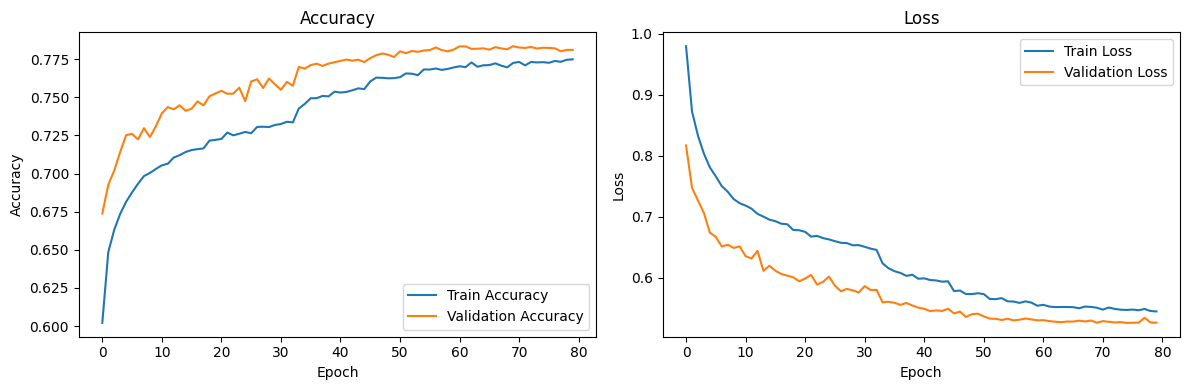

In [31]:
plt.figure(figsize=(12, 4))

# Plot accuracy history
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss history
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy * 100:.4f}%")

811/811 [==============================] - 1s 952us/step - loss: 0.5162 - accuracy: 0.7849
Loss: 0.5161770582199097, Accuracy: 78.4864%


In [33]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

811/811 [==============================] - 1s 782us/step
Accuracy: 78.49%


In [34]:
print(classification_report(y_test, y_pred, target_names=EVENTS_AASM_NEU))

              precision    recall  f1-score   support

         REM       0.85      0.84      0.84      3175
      NREM 1       0.77      0.75      0.76      8431
      NREM 2       0.71      0.73      0.72      6063
      NREM 3       0.83      0.81      0.82      4007
        Wake       0.83      0.88      0.86      4275

    accuracy                           0.78     25951
   macro avg       0.80      0.80      0.80     25951
weighted avg       0.78      0.78      0.78     25951



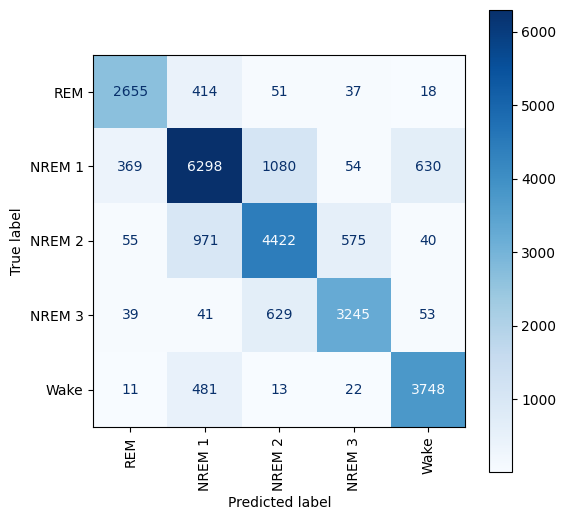

In [35]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=EVENTS_AASM_NEU.keys())
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues,ax=ax, values_format='d', xticks_rotation=90)
ax.grid(False)
plt.show()